In [201]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, SystemMessage, HumanMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph import StateGraph, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display
import json 

load_dotenv()

True

In [202]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]
    initial_route: str | None
    route: list[str] | None      
    sql_results: list[str] | None
    vector_results: list[str] | None
    question_results: list[str] | None
    plan: list[dict] | None
    current_task: dict | None


In [203]:
main_llm = ChatOpenAI(model="gpt-4o")
planner_llm = ChatOpenAI(model="gpt-4o-mini")
sql_llm = ChatOpenAI(model="gpt-4o-mini")
vect_llm = ChatOpenAI(model="gpt-4o-mini")
question_llm = ChatOpenAI(model="gpt-4o-mini")


In [204]:
@tool
def run_sql_query(query: str):
    """Run a database query and return the results."""
    if "calls yesterday" in query.lower():
        return "42 calls were made yesterday."
    elif "today" in query.lower() or "current" in query.lower():
        return "17 calls so far today."
    else:
        return "No data found."
    
@tool
def search_vector_db(query: str):
    """Perform a semantic vector search."""
    return f"Search results for '{query}' (vector-based)."

In [205]:
sql_llm_bound = sql_llm.bind_tools([run_sql_query])
vect_llm_bound = vect_llm.bind_tools([search_vector_db])
question_llm_bound = question_llm.bind_tools([])

In [206]:
def main_agent(state: AgentState) -> AgentState:
    """The coordinator decides whether to answer directly or hand off to another agent."""

    system = SystemMessage(content="""
    You are a coordinator. Decide if the user's request requires:
    a lookup by another agent for more information, or if you can answer directly.
    Use the following guidelines:
    - You can only answer directly if the request is simple and factual.
    - If you choose lookup by another agent, answer explicitly with the phrase 'agent lookup'.
    """)

    response = main_llm.invoke([system] + state["messages"])
    text = response.content.lower()
    print("Coordinator decision:", text)

    # Decision
    if "agent lookup" in text:
        # Tell the graph to send this to another agent (like a planner)
        state["initial_route"] = "agent_lookup"
        return state
    else:
        # The coordinator can answer directly
        return {
            **state,
            "messages": state["messages"] + [response],
            "route": [],
        }

In [207]:
def planner_agent(state: AgentState) -> AgentState:
    system = SystemMessage(content="""
You are a task planning agent that converts the user's request into an explicit, structured plan.

### Your Goal:
Break the user's request into **atomic, executable subtasks**.
Each subtask should have:
- a short `task` description,
- a `type` (which determines the next agent),
- a unique `id`,
- and a `done` flag (initially false).

### Rules for deciding the `type`:
- Use `"sql_agent"` for anything involving structured or numeric data (calls, sales, performance metrics, database queries, etc.)
- Use `"vector_agent"` for anything involving semantic or fuzzy searches (complaints, issues, topics, feedback, similarity search, etc.)
- If the user just asks a direct question that doesn't require a tool, make a single `"direct_answer"` task.

### Output Format:
You must respond **only in valid JSON**, no explanation or commentary.

Example output for a simple SQL question:
```json
{
  "plan": [
    {"id": 1, "task": "Get the number of calls made yesterday", "type": "sql_agent", "done": false}
  ]
}
"""
)
    
    response = planner_llm.invoke([system] + state["messages"])
    print("Planner output:", response.content)
    
    try:
        plan = json.loads(response.content)["plan"]
    except Exception:
        plan = []
    print("Final plan:", plan)
    
    return {
        **state,
        "messages": state["messages"] + [response],
        "plan": plan
    }

In [208]:
def agent_router(state: AgentState) -> AgentState:
    plan = state.get("plan") or []
    
    # Find the next unfinished task
    for task in plan:
        if not task.get("done"):
            next_route = task["type"]  # like "sql_agent" or "vector_agent"
            current_task = task
            print("Routing to next task:", next_route, "with task:", current_task)
            return {
                **state,
                "route": [next_route],
                "current_task": task
            }
    
    # If all tasks are done, go to summarizer
    return {
        **state,
        "route": ["summarizer_agent"],
        "current_task": None
    }

In [ ]:
def agent_router_helper(state: AgentState) -> str:
    plan = state.get("plan") or []
    
    # Find the next unfinished task
    for task in plan:
        if not task.get("done"):
            next_route = task["type"]  # "sql_agent" or "vector_agent"
            return next_route
    
    # If all tasks are done, go to summarizer
    return "summarizer_agent"

In [210]:
def sql_agent(state: AgentState) -> AgentState: 
    system = SystemMessage(content="You are an expert SQL generator. " 
    "You are an SQL agent. For every task, you MUST call the tool `run_sql_query`. " 
    "Do NOT answer directly.Respond ONLY using a tool invocation in the correct format.")
    
    # get current task
    plan = state["plan"]
    current = next(t for t in plan if not t["done"])

    # send task as a message, not a dict
    task_msg = HumanMessage(content=current["task"])

    response = sql_llm_bound.invoke([system, task_msg])
    print("SQL Agent response:", response.content)

    # store result
    sql_results = list(state.get("sql_results") or [])
    sql_results.append(response.content)

    # mark task done
    for t in plan:
        if t["id"] == current["id"]:
            t["done"] = True

    return {
        **state,
        "messages": state["messages"] + [response],
        "sql_results": sql_results,
        "plan": plan
    }

In [211]:
def vector_agent(state: AgentState) -> AgentState: 
    system = SystemMessage(content="You perform expert semantic vector searches.")
    plan = state["plan"]

    # Get next unfinished task
    current = next(t for t in plan if not t["done"])

    task_msg = HumanMessage(content=current["task"])

    response = vect_llm_bound.invoke([system, task_msg])
    print("Vector Agent response:", response.content)

    # Save vector search results
    vector_results = list(state.get("vector_results") or [])
    vector_results.append(response.content)

    # Mark done
    for t in plan:
        if t["id"] == current["id"]:
            t["done"] = True
            break

    return {
        **state,
        "messages": state["messages"] + [response],
        "vector_results": vector_results,
        "plan": plan
    }

In [212]:
def question_agent(state: AgentState) -> AgentState: 
    system = SystemMessage(content="You answer direct questions clearly and concisely.")
    plan = state["plan"]

    current = next(t for t in plan if not t["done"])

    task_msg = HumanMessage(content=current["task"])

    response = question_llm.invoke([system, task_msg])
    print("Question Agent response:", response.content)

    # Save the answer
    question_results = list(state.get("question_results") or [])
    question_results.append(response.content)

    # Mark done
    for t in plan:
        if t["id"] == current["id"]:
            t["done"] = True
            break

    return {
        **state,
        "messages": state["messages"] + [response],
        "question_results": question_results,
        "plan": plan
    }

In [ ]:
def summarizer_agent(state: AgentState) -> AgentState:
    print("Summarizer Agent state:", state)

    # Get initial user prompt
    initial_user_prompt = next(
        (msg.content for msg in state["messages"] if getattr(msg, "type", None) == "human"),
        None
    )

    # Collect tool results with their queries
    tool_results_with_context = []

    # Build a mapping from tool_call_id -> ToolMessage
    tool_messages = {
        msg.tool_call_id: msg for msg in state["messages"]
        if getattr(msg, "type", None) == "tool"
    }

    # Look for AI messages that called tools
    for msg in state["messages"]:
        if getattr(msg, "type", None) == "ai" and hasattr(msg, "tool_calls") and msg.tool_calls:
            for call in msg.tool_calls:
                tool_msg = tool_messages.get(call["id"])
                if tool_msg and tool_msg.content.strip():
                    tool_results_with_context.append(
                        f"[Tool: {call['name']}] Query: {call['args'].get('query','')} Result: {tool_msg.content.strip()}"
                    )

    # Also include any non-tool results (from sql_results, vector_results, question_results)
    sql_results = state.get("sql_results") or []
    vector_results = state.get("vector_results") or []
    question_results = state.get("question_results") or []

    all_results = sql_results + vector_results + question_results + tool_results_with_context

    # Combine for LLM
    combined_info = (
        f"The user asked: {initial_user_prompt}\n\n"
        "And this was found:\n"
        + "\n".join(f"- {result}" for result in all_results)
    )

    print("Summarizer combining info:", combined_info)

    # Produce summary
    system = SystemMessage(content="Summarize the following tool results clearly and concisely.")
    response = main_llm.invoke([system, HumanMessage(content=combined_info)])

    print("Summarizer final summary:", response.content)

    return {
        "messages": state["messages"] + [response],
        "route": [END],
    }


In [214]:
def initial_route(state: AgentState):
    """Decide next node after main_agent."""
    if state.get("initial_route") == "agent_lookup":
        return "planner_agent"
    return END

In [215]:
workflow = StateGraph(AgentState)

workflow.add_node("main_agent", main_agent)
workflow.add_node("planner_agent", planner_agent)
workflow.add_node("agent_router", agent_router)
workflow.add_node("sql_agent", sql_agent)
workflow.add_node("vector_agent", vector_agent)
workflow.add_node("question_agent", question_agent)
workflow.add_node("summarizer_agent", summarizer_agent)
workflow.add_node("sql_tools", ToolNode([run_sql_query]))
workflow.add_node("vector_tools", ToolNode([search_vector_db]))

workflow.set_entry_point("main_agent")

workflow.add_conditional_edges(
    "main_agent", 
    initial_route, 
    {"planner_agent": "planner_agent", END: END}
)

workflow.add_edge("planner_agent", "agent_router")

workflow.add_conditional_edges(
    "agent_router",
    agent_router_helper, 
    {
        "sql_agent": "sql_agent",
        "vector_agent": "vector_agent",
        "direct_answer": "question_agent",
        "summarizer_agent": "summarizer_agent"
    }
)

workflow.add_edge("sql_agent", "sql_tools")
workflow.add_edge("vector_agent", "vector_tools")

workflow.add_edge("sql_tools", "agent_router")
workflow.add_edge("vector_tools", "agent_router")
workflow.add_edge("question_agent", "agent_router")
workflow.add_edge("summarizer_agent", END)



graph = workflow.compile()

In [216]:
initial_state = AgentState(
    messages=[HumanMessage(content="I want to know the top 3 tech companies by market cap. and the weather in New York.")],
    initial_route=None,
    route=None,
    sql_result=None,
    vector_result=None,
)

result = graph.invoke(initial_state)

# Print results
print("=== Final State ===")
print(result["route"])
print("=== Messages ===")
for m in result["messages"]:
    role = m.__class__.__name__.replace("Message", "")
    print(f"\n[{role.upper()}]\n{m.content}")

Coordinator decision: agent lookup
Planner output: {
  "plan": [
    {"id": 1, "task": "Get the top 3 tech companies by market cap", "type": "sql_agent", "done": false},
    {"id": 2, "task": "Get the current weather in New York", "type": "direct_answer", "done": false}
  ]
}
Final plan: [{'id': 1, 'task': 'Get the top 3 tech companies by market cap', 'type': 'sql_agent', 'done': False}, {'id': 2, 'task': 'Get the current weather in New York', 'type': 'direct_answer', 'done': False}]
Routing to next task: sql_agent with task: {'id': 1, 'task': 'Get the top 3 tech companies by market cap', 'type': 'sql_agent', 'done': False}
SQL Agent response: 
Routing to next task: direct_answer with task: {'id': 2, 'task': 'Get the current weather in New York', 'type': 'direct_answer', 'done': False}
Question Agent response: I don’t have real-time weather data access. To get the current weather in New York, please check a weather website or app.
Summarizer Agent state: {'messages': [HumanMessage(cont

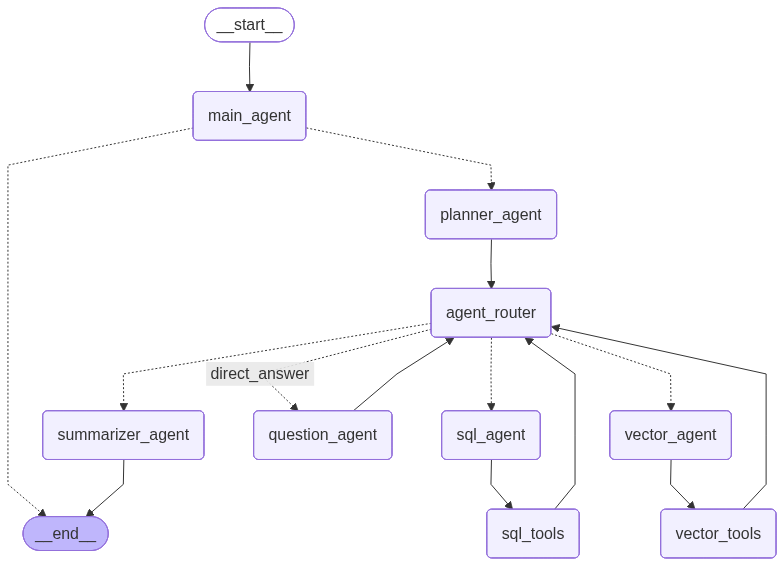

In [217]:
display(Image(graph.get_graph().draw_mermaid_png()))
